<a name="1common."></a>
## Содержание:
* [1. Описание проекта, описание данных, загрузка и импорт библиотек](#1.)
* [2. Предобработка данных](#2.)
* [3. Исследовательский анализ данных](#3.)
* [4. Бинарная классификация](#4.)
     - [4.1. Корреляционная матрица](#4.1.)
     - [4.2. Обучение моделей](#4.2.)
     - [4.3. Важность признаков](#4.3.)
* [5. Кластеризация клиентов](#5.)
     - [5.1. Иерархическая кластеризация](#5.1.)
     - [5.2. K-Means](#5.2.)
* [6. Общий вывод](#6.)

 <a name="1."><a/><br/>
    <font size ="5"><b>1. Описание проекта, описание данных, загрузка и импорт библиотек</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
* 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:
* 'gender' — пол
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)

Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* 'Phone' — наличие контактного телефона
* 'Age' — возраст
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
* 'Group_visits' — факт посещения групповых занятий
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

**Задача:**
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    
    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.

In [1]:
# для работы с математическими опперациями
import numpy as np

# для работы с таблицами
from pandas import DataFrame
import pandas as pd

# для графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

# для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.to_csv('gym_churn.csv')

 <a name="2."><a/><br/>
    <font size ="5"><b>2. Предобработка данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [3]:
# функция для поиска пропусков и их количества от общего числа данных
def missing_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Пропуски", 1: "% от общего"})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns['Пропуски'] != 0].sort_values(
        "% от общего", ascending=False).round(1)
    print("Данная таблица имеет " + str(df.shape[1]) + " столбцов.\n"
          "В ней " + str(mis_val_table_ren_columns.shape[0]) +
          " столбцов с пропусками.")
    print('В ней', len(df), 'строк')
    print('Данная таблица имеет', df.duplicated().sum(), 'дубликатов')
    print("Дубликатов = {:.1%}".format(df.duplicated().sum() / len(df)))
    print(df.dtypes)
    return mis_val_table_ren_columns


missing_table(df)

Данная таблица имеет 14 столбцов.
В ней 0 столбцов с пропусками.
В ней 4000 строк
Данная таблица имеет 0 дубликатов
Дубликатов = 0.0%
gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object


,Пропуски,% от общего


Пропусков и дубликатов нету, все типы данных нас устраивают

 <a name="3."><a/><br/>
    <font size ="5"><b>3. Исследовательский анализ данных</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [4]:
# посмотрим на основные характеристики описательной статистики
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
# выведем средние значения по двум нашим группам 'Остался' = 0 и 'Ушел' = 1
df.groupby('Churn')['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
                    'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 'Lifetime'].mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime
Churn,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,4.711807
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,0.990575


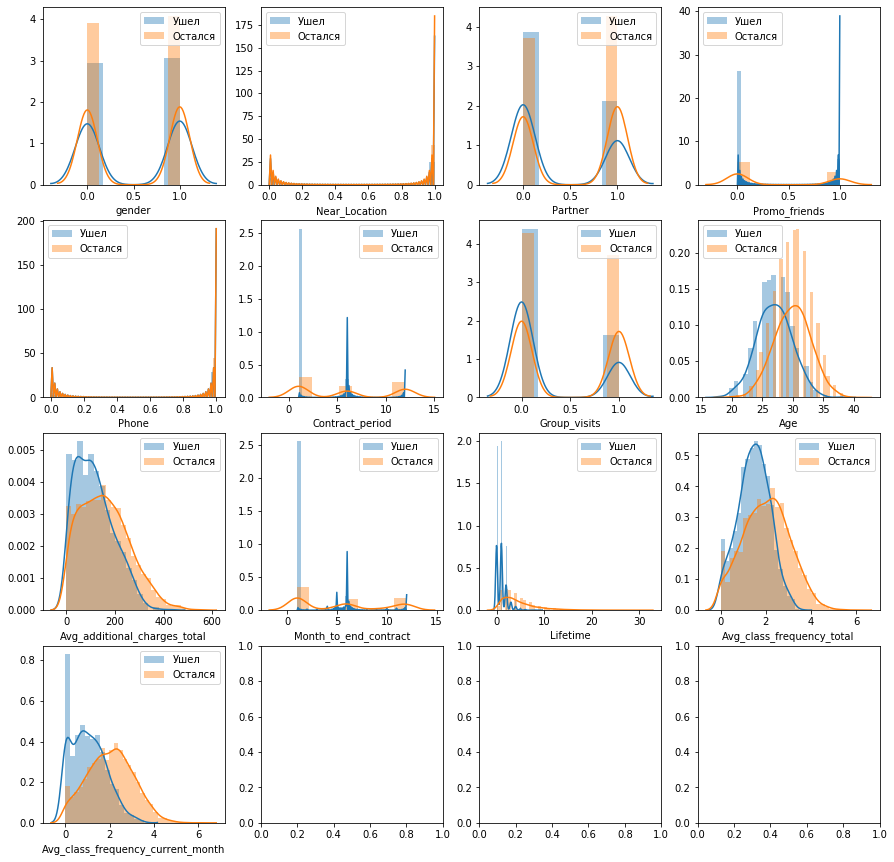

In [6]:
# посмотрим на распределение каждого признака по двум группам
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
ax_iter = iter(axs.flat)
for col in df.drop('Churn', axis=1).columns:
    ax = next(ax_iter)
    sns.distplot(df.query('Churn == 1')[col], ax=ax)
    sns.distplot(df.query('Churn == 0')[col], ax=ax)
    ax.legend(labels=['Ушел', 'Остался'])

**Вывод:**

На данном этапе прослеживаться закономерности
1. Пол не влияет на отток клиентов
* Ближайшее расположение влияет не сильно
* Клиенты пришедшие по акции приведи друга, остаются чаще
* Чем больше контрактный период, тем меньше оттока
* Средний возраст остающихся 30 лет, оттока 27 лет
* Средне время существование клиента в группе отток 1 месяц, в группе оставшиеся 5 месяцев

 <a name="4."><a/><br/>
    <font size ="5"><b>4. Бинарная классификация</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
<a name="4.1."><a/><br/>
    <font size ="4"><b>4.1.Корреляционная матрица</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Перед нами классическая задача бинарной классификации. Было принято решение применить 3 алгоритма: Логистическая регрессия, Случайный лес, Градиентный бустинг. Оценка качества алгоритма будет происходить 5 основными метриками: accuracy, precision_score, recall_score, f1_score, roc_auc_score.

Сначала посмотрим на матрицу кореляций и избавимся от проблемы мультиколлинеарности, удалив совпадающие столбцы.

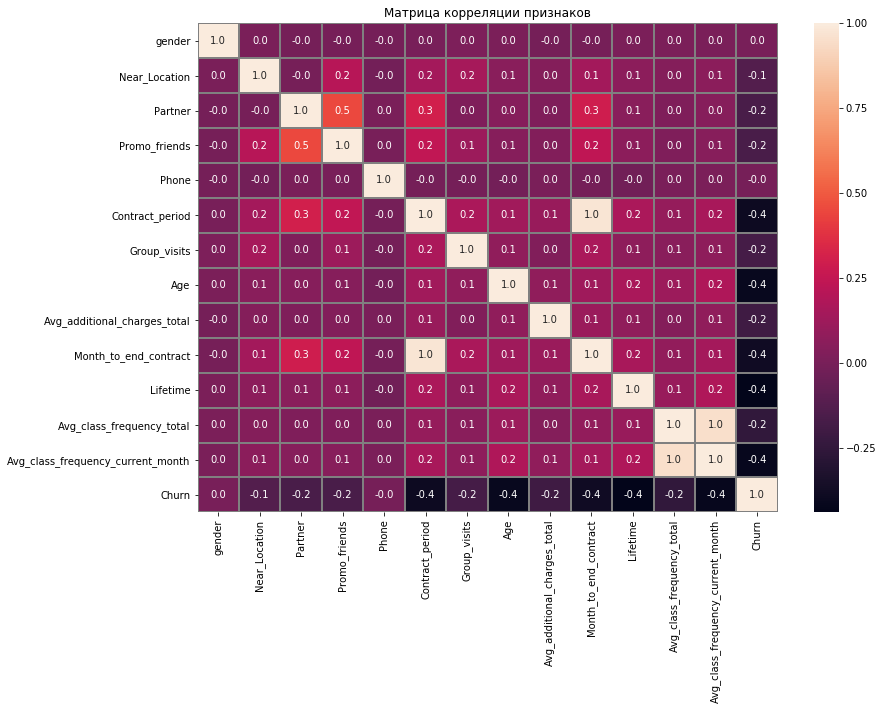

In [7]:
corr = df.corr()
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляции признаков')
sns.heatmap(corr, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Столбцы 'Avg_class_frequency_current_month', 'Avg_class_frequency_total' и столбцы 'Month_to_end_contract', 'Contract_period' имеют единичную положительную корреляцию. Это значит, что при переводе наших признаков в векторное пространство они будут коллинеарны друг с другом и это приведет к искажению результатов.

Удалим их

In [8]:
df.drop(['Avg_class_frequency_current_month',
         'Month_to_end_contract'], axis=1, inplace=True)

<a name="4.2."><a/><br/>
    <font size ="4"><b>4.2.Обучение моделей</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

models = [RandomForestClassifier(),  # случайный лес
          GradientBoostingClassifier(),  # ГБ
          LogisticRegression()  # логистическая регрессия
          ]

# стандартизируем данные для минимизации ошибки
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающую и валидационную выборку
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [10]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    tmp['Model'] = m[:m.index('(')]    
    #для каждого столбцам результирующего набора
    #обучаем модель
    model.fit(X_train_st, y_train) 
    #вычисляем метрики оценки качества
    pr = model.predict(X_test_st)
    tmp['accuracy'] = accuracy_score(y_test, pr)
    tmp['precision_score'] = precision_score(y_test, pr)
    tmp['recall_score'] = recall_score(y_test, pr)
    tmp['f1_score'] = f1_score(y_test, pr)
    tmp['roc_auc_score'] = roc_auc_score(y_test, model.predict_proba(X_test_st)[:,1])
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])
TestModels.set_index('Model', inplace=True)
TestModels.sort_values(by = 'accuracy', ascending = False)

,accuracy,precision_score,recall_score,f1_score,roc_auc_score
Model,,,,,
GradientBoostingClassifier,0.89875,0.800000,0.787879,0.793893,0.951030
LogisticRegression,0.89875,0.788177,0.808081,0.798005,0.953086
RandomForestClassifier,0.88250,0.776596,0.737374,0.756477,0.919175


In [11]:
# подберем циклом 1 гипперпараметр = n_estimators
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
accuracy_results = []
roc_auc_result = []
f1_scors = []
for estimator in n_estimators:
   rf = GradientBoostingClassifier(n_estimators=estimator)
   rf.fit(X_train_st, y_train)
   y_pred = rf.predict(X_test_st)
   ac = accuracy_score(y_test, y_pred)
   accuracy_results.append(ac)
   f1 = f1_score(y_test, y_pred)
   f1_scors.append(f1)
   y_prob = rf.predict_proba(X_test_st)[:,1]
   roc = roc_auc_score(y_test, y_prob)
   roc_auc_result.append(roc)

In [12]:
d = {'n_estimators': n_estimators, 
     'accuracy_results': accuracy_results,
    'roc_auc_result': roc_auc_result,
    'f1_scors': f1_scors}
pf = pd.DataFrame(data=d)
pf.sort_values(by = 'accuracy_results', ascending = False).head(3)

,n_estimators,accuracy_results,roc_auc_result,f1_scors
7,80,0.90375,0.950997,0.803069
4,50,0.90250,0.949533,0.800000
6,70,0.90250,0.950560,0.801020


Гипперпараметр n_estimators = 30, улучшает наши метрики. accuracy_results на 0,7% и f1_scors на 1,5%. Для более глубокого обучения можно воспользоваться методом главных компонент для снижения размерности и применить модули RandomizedSearchCV и GridSearchCV.

**Вывод:**

Алгоритм GradientBoostingClassifier и LogisticRegression показали самые лучшие метрики. Остановимся на GradientBoostingClassifier, так как precision_score(точность) у него выше

* accuracy = 0.90 - наш алгоритм определил 90% тестовой выборки правильно
* precision_score = 0.80 - 80% предсказаний оттока клиента оказались таковыми
* recall_score = 0.78 - 78% людей из тестовой выборки были отнесены к 1(отток)
* f1_score = 0.81 - гармоническое среднее между точностью и полнотой
* roc_auc_score = 0.95 - c 95% вероятностью наш алгоритм определит попадание клиента в отток

<a name="4.3."><a/><br/>
    <font size ="4"><b>4.3.Важность признаков</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [13]:
# обучим финальную модель
final_model = GradientBoostingClassifier()
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)
importances = final_model.feature_importances_
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
df1 = pd.DataFrame(importances, X.columns.tolist(), columns=['weight'])
df1.sort_values(by='weight', ascending=False)

,weight
Lifetime,0.552886
Contract_period,0.162438
Age,0.126355
Avg_class_frequency_total,0.095953
Avg_additional_charges_total,0.047750
Group_visits,0.009192
Promo_friends,0.002537
Near_Location,0.001427
Partner,0.000735
gender,0.000446


**Вывод:**

Отсортировав признаки по важности для точной работы нашего алгоритма, мы увидели, что Lifetime имеет вес больше 0.55. Можно сделать вывод, что на нашу метрику Churn имеет сильное влияние срок пользования нашим сервисов у клиентов.

 <a name="5."><a/><br/>
    <font size ="5"><b>5. Кластеризация клиентов</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)
<a name="5.1."><a/><br/>
    <font size ="4"><b>5.1.Иерархическая кластеризация</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [14]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler()  
x_sc = scaler.fit_transform(df.drop('Churn', axis = 1))
linked = linkage(x_sc, method='ward')

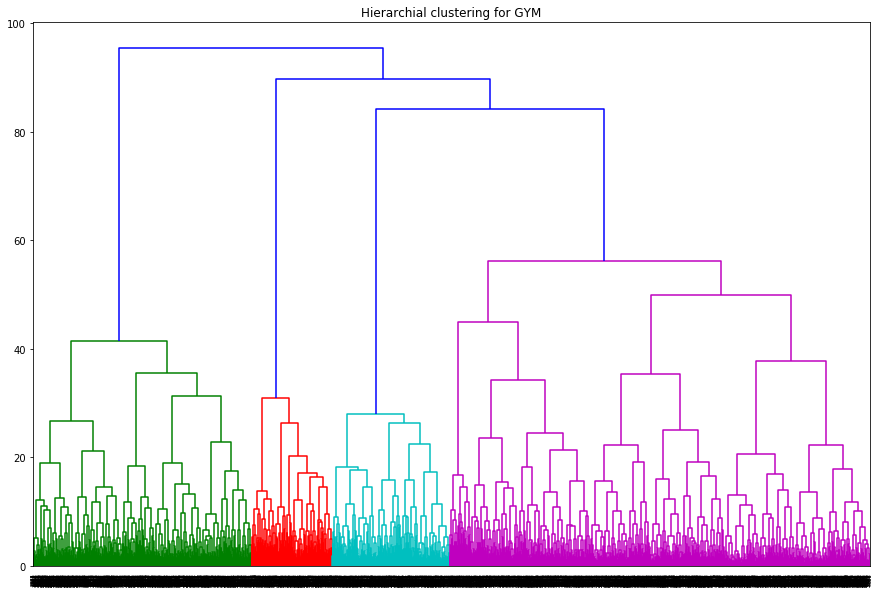

In [15]:
# построим дендрограмму иерархической кластеризации для определения оптимального числа кластеров
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Было принято решение принять за оптимальное число кластеров число 5. Теперь применим алгоритм K-Means с заданным числом кластеров. 

<a name="5.2."><a/><br/>
    <font size ="4"><b>5.2.K-Means</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [16]:
km = KMeans(n_clusters=5)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['clusters'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Метрика силуэта: {:.2f}'.format(silhouette_score(x_sc, labels)))

Метрика силуэта: 0.14


Наши кластеры плохо описывают структуру наших данных, это видно и по дендрограмме

In [17]:
df.groupby(['clusters'])['Age'].count()

clusters
0     386
1     866
2     996
3    1195
4     557
Name: Age, dtype: int64

Разделение по кластерам клиентов равномерно

In [18]:
df.groupby(['clusters']).mean().reset_index(
).sort_values(by='Churn', ascending=False)

,clusters,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
3,3,0.508787,1.000000,0.185774,0.056067,1.0,1.948954,0.315481,27.952301,124.542335,2.120502,1.551527,0.495397
4,4,0.500898,0.000000,0.488330,0.077199,1.0,2.978456,0.231598,28.685817,137.277472,2.978456,1.762672,0.402154
0,0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839
2,2,0.497992,0.994980,0.893574,1.000000,1.0,6.863454,0.520080,29.534137,152.377724,4.226908,1.955528,0.131526
1,1,0.526559,0.995381,0.439954,0.011547,1.0,6.994226,0.531178,30.751732,179.042378,5.744804,2.328829,0.012702


Можно выделить из 5 кластеров 3 основным направления:
1. Кластер 4, 3 - отток 50% и 40% соответственно
2. Кластер 2 - отток 26%
3. Кластер 0 и 1 - отток почти 13% и 1% соответственно

По средним значениям можно заметить, что с ростом показателя Lifetime, падает показатель Churn. В самом последнем кластера вообще до нуля. Так же влияет показатель Contract_period,клиенты, купившие абонемент больше чем на 3 месяца, останутся с нами вероятней всего. Средний возраст тоже отличается, у группы людей со средним возрастом 31 год, вероятность оттока намного ниже, чем с возрастом 28 лет. Посещение групповых визитов тоже положительно влияет на уменьшение оттока клиентов. Увеличение среднего чека на смежные покупки тоже положительно влияет на отток, но это скорее следствие, чем причина

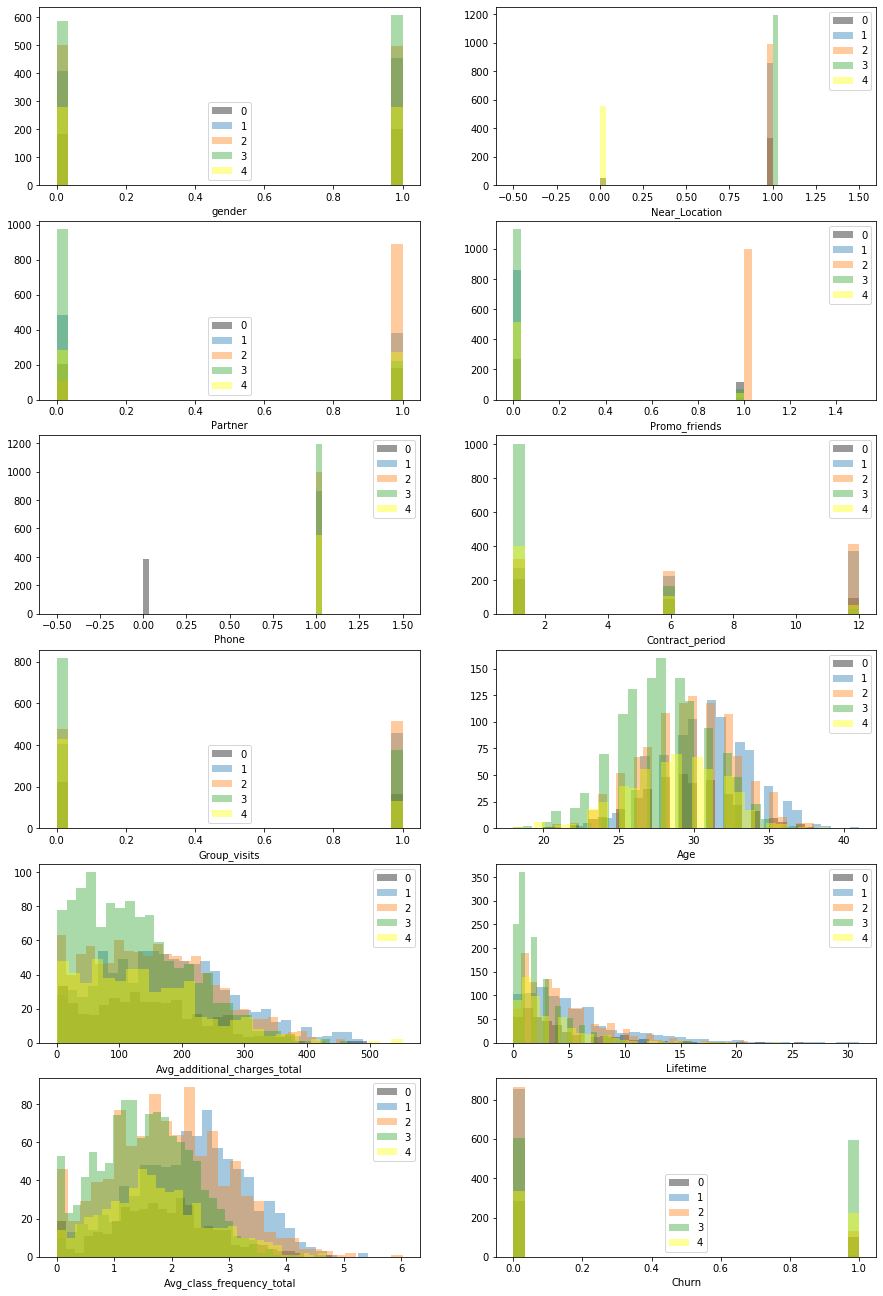

In [19]:
fig, axs = plt.subplots(6, 2, figsize=(15, 23))
ax_iter = iter(axs.flat)
for col in df.drop('clusters', axis=1).columns:
    ax = next(ax_iter)
    bins = 30
    sns.distplot(df.query('clusters == 0')[
                 col], bins=bins, ax=ax, kde=False, color='black')
    sns.distplot(df.query('clusters == 1')[col], bins=bins, ax=ax, kde=False)
    sns.distplot(df.query('clusters == 2')[col], bins=bins, ax=ax, kde=False)
    sns.distplot(df.query('clusters == 3')[col], bins=bins, ax=ax, kde=False)
    sns.distplot(df.query('clusters == 4')[
                 col], bins=bins, ax=ax, kde=False, color='yellow')
    ax.legend(labels=['0', '1', '2', '3', '4'])

По распределению можно сделать такой же вывод, как и по таблице средних значений. Чем дольше клиент с нами, тем меньше вероятность, что он уйдет.

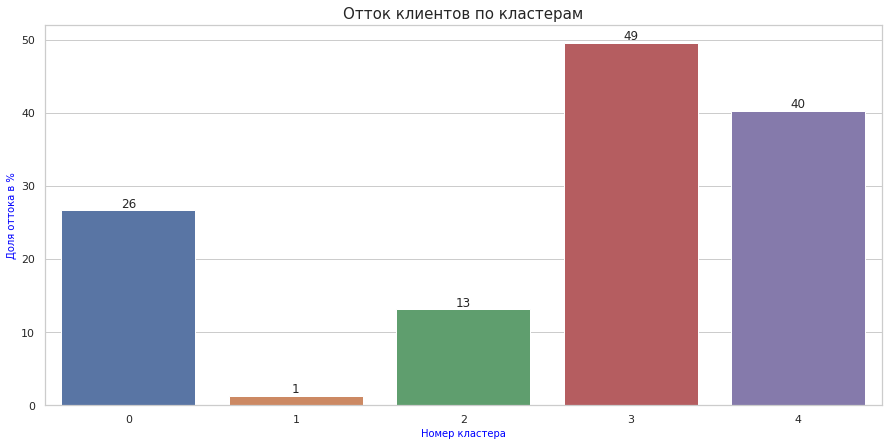

In [20]:
# посчитаем процент оттока в каждом кластере
dol_df = (df.groupby('clusters')['Churn'].sum(
) / df.groupby('clusters')['Churn'].count() * 100).round(2).reset_index()

# построим barplot
plt.figure(figsize=(15, 7))
sns.set(style="whitegrid")
sns.barplot(x=dol_df['clusters'], y=dol_df['Churn'])
for i, val in enumerate(dol_df['Churn'].values):
    plt.text(i, val, int(val), horizontalalignment='center',
             verticalalignment='bottom', fontdict={'fontweight': 500, 'size': 12})
plt.ylabel('Доля оттока в %', fontsize=10, color='blue')
plt.xlabel('Номер кластера', fontsize=10, color='blue')
plt.title('Отток клиентов по кластерам', fontsize=15)
plt.show()

In [21]:
# посмотрим на два основных кластера
df.query('clusters == 4 or clusters == 0').groupby(['clusters']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
clusters,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839
4,0.500898,0.000000,0.488330,0.077199,1.0,2.978456,0.231598,28.685817,137.277472,2.978456,1.762672,0.402154


Можно сформировать портреты клиентов:
1. Уходят
    * доля участников партнерских программ 18%
    * контакт 3 месяца и меньше
    * групповые визиты 31%
    * средний возраст 28 лет
    * время пользования сервисом 2 месяца
    * среднее посещение в неделю 1,5 раз
    * 124 средняя выручка с других услуг в неделю
2. Остаются 
    * доля участников партнерских программ 44%
    * контакт больше 6 месяцев
    * групповые визиты 53%
    * средний возраст 31 год
    * время пользования сервисом 6 месяцев
    * среднее посещение в неделю 2,3 раза
    * 180 средняя выручка с других услуг в неделю

 <a name="6."><a/><br/>
    <font size ="5"><b>6. Общий вывод</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Лучшие показатели у алгоритма, предсказывающего отток клиентов GradientBoostingClassifier.

На отток клиентов влияет 4 основных признака
1. Время пользования сервисом
2. Срок абонемента в месяцах
3. Возраст
4. Участие в групповых программах
5. Участие в партнерских программах

Их этого следуют рекомендации:
1. Изменить маркетинговую программу и ценообразование абонементов. Увеличить бонусы за покупку длительного контракта или сделать цену более привлекательной на длительные контракты.
2. Увеличить рекламный бюджет на категорию молодых людей в возрасте 30 лет.
3. Улучшить программу групповых программ, и привлекать больше людей на них.
4. Обратить внимание на партнерские программы, сделать их более привлекательными. 